Notebook version of test.py for testing how to pass stimuli through and get resps from audio ResNet-18

In [1]:
# generic imports - from your venv
import os
import torch
from torch.optim import *
import torchvision
from torchvision.transforms import *
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from types import SimpleNamespace
import numpy as np
import json
import argparse
import csv

# custom imports - from the repository
from utils import hook_fn, run_inference
from model import AVENet
from datasets import GetAudioVideoDataset

In [4]:
# arguments
args = SimpleNamespace(
    data_path = '/home/eyakub/scratch/test', # directory to the audios you want the model to respond to, 
    summaries = '/home/eyakub/scratch/H.pth.tar', # path to saved weights of trained model H from Chen et al., 2020
    pool = "avgpool", # the pooling function for model H
    batch_size = 32,
    n_classes=309,
    model_depth = 18,
    resnet_shortcut = 'B'
    )

In [5]:
# init network
os.environ["CUDA_VISIBLE_DEVICES"]="0"
model= AVENet(args) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [6]:
# load pretrained models
checkpoint = torch.load(args.summaries, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
print('loaded pretrained model.')

loaded pretrained model.


In [7]:
# create dataloader
testdataset = GetAudioVideoDataset(args,  mode='test')
testdataloader = DataLoader(testdataset, batch_size=args.batch_size, shuffle=False, num_workers = 16)
print("Loaded dataloader.")

['audio0.wav', 'audio1.wav', 'audio2.wav', 'audio3.wav', 'audio10.wav', 'audio30.wav']
6
# of audio files = 6 
Loaded dataloader.


/home/eyakub/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# actually running the model and getting features from our layer of choice 
model.eval()

hook = model.audnet.layer4[1].conv2.register_forward_hook(hook_fn)
output_features = run_inference(model, testdataloader, device=device)
hook.remove()

getting item 0
getting item 1
getting item 2
getting item 3
getting item 4
getting item 5


In [9]:
len(output_features[0][0][0][0])

32

In [10]:
output_features = torch.cat(output_features, dim=0).numpy()

In [11]:
output_features.shape

(6, 512, 9, 32)

(array([5.2000e+01, 6.6300e+02, 7.3050e+03, 5.2860e+04, 7.1617e+04,
        1.1936e+04, 2.2860e+03, 5.6900e+02, 1.4800e+02, 2.0000e+01]),
 array([-0.37985516, -0.28598657, -0.19211797, -0.09824939, -0.0043808 ,
         0.08948779,  0.18335637,  0.27722496,  0.37109357,  0.46496215,
         0.55883074]),
 <BarContainer object of 10 artists>)

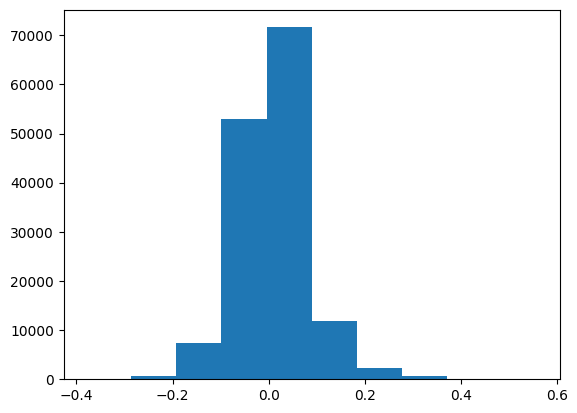

In [12]:
import matplotlib.pyplot as plt
plt.hist(np.nanmean(np.reshape(output_features,(6,-1)),axis=0))